In [3]:
from __future__ import print_function
import pymks
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


In [6]:
sample_size = 100
n_samples = 4 * [sample_size]
size = (101, 101)
elastic_modulus = (1.3, 75)
poissons_ratio = (0.42, .22)
macro_strain = 0.001
n_phases = 2
grain_size = [(40, 2), (10, 2), (2, 40), (2, 10)]
v_frac = [(0.7, 0.3), (0.6, 0.4), (0.3, 0.7), (0.4, 0.6)]
per_ch = 0.1

In [7]:
from pymks.datasets import make_elastic_stress_random


dataset, stresses = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size,
                                                 elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio,
                                                 macro_strain=macro_strain, volume_fraction=v_frac,
                                                 percent_variance=per_ch)

C:\Users\Eric\Anaconda3\envs\Material\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Eric\Anaconda3\envs\Material\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


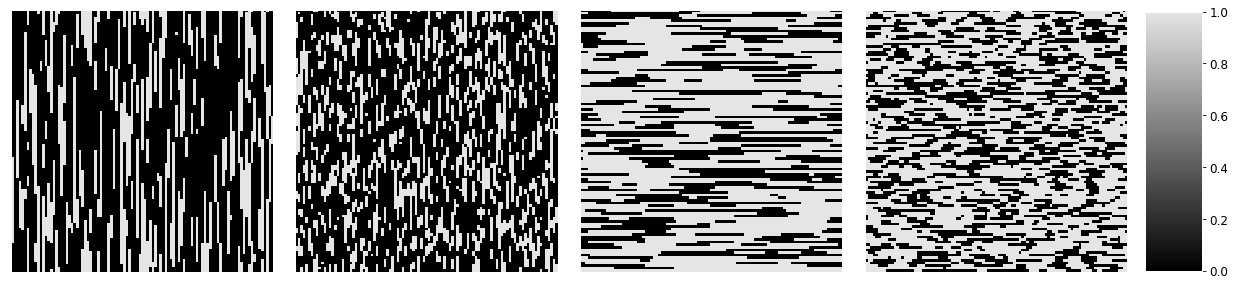

In [8]:
from pymks.tools import draw_microstructures
examples = dataset[::sample_size]
draw_microstructures(examples)

In [10]:
from pymks import MKSHomogenizationModel
from pymks import PrimitiveBasis


p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSHomogenizationModel(basis=p_basis, correlations=[(0, 0)], periodic_axes=[0, 1])

In [11]:
from sklearn.cross_validation import train_test_split


flat_shape = (dataset.shape[0],) + (dataset[0].size,)
data_train, data_test, stress_train, stress_test = train_test_split(
    dataset.reshape(flat_shape), stresses, test_size=0.2, random_state=3)

In [12]:
from sklearn.grid_search import GridSearchCV


params_to_tune = {'degree': np.arange(1, 4), 'n_components': np.arange(2, 8)}
fit_params = {'size': dataset[0].shape}
gs = GridSearchCV(model, params_to_tune, fit_params=fit_params).fit(data_train, stress_train)

In [13]:
print('Order of Polynomial', gs.best_estimator_.degree)
print('Number of Components', gs.best_estimator_.n_components)
print('R-squared Value', np.allclose(gs.score(data_test, stress_test), 0.863, rtol=1e-1))

Order of Polynomial 3
Number of Components 3
R-squared Value True


In [ ]:
from pymks.tools import draw_gridscores_matrix

draw_gridscores_matrix(gs, ['n_components', 'degree'], score_label='R-Squared',
                       param_labels=['Number of Components', 'Order of Polynomial'])

In [ ]:
from pymks.tools import draw_gridscores

gs_deg_1 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 1]
gs_deg_2 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 2]
gs_deg_3 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 3]

draw_gridscores([gs_deg_1,  gs_deg_2, gs_deg_3], 'n_components',
                data_labels=['1st Order', '2nd Order', '3rd Order'],
                param_label='Number of Components', score_label='R-Squared')

In [ ]:
model = gs.best_estimator_

In [ ]:
from pymks.tools import draw_components_scatter


stress_predict = model.predict(data_test)
draw_components_scatter([model.reduced_fit_data[:, :3],
                         model.reduced_predict_data[:, :3]],
                        ['Training Data', 'Testing Data'],
                        legend_outside=True)

In [ ]:

from pymks.tools import draw_goodness_of_fit


fit_data = np.array([stresses, model.predict(dataset)])
pred_data = np.array([stress_test, stress_predict])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Testing Data'])